In [11]:
import os
import sys
import json
import heapq
import graphviz as gv
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from collections import deque


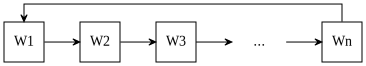

In [2]:
g = gv.Digraph()
g.graph_attr['splines'] = 'ortho'
g.graph_attr['nodesep'] = '0.5'
g.graph_attr['rankdir'] = 'TB'
g.graph_attr['bgcolor'] = 'transparent'
g.node_attr['shape'] = 'square'
g.edge_attr['arrowhead'] = 'vee'
g.edge_attr['arrowsize'] = '0.7'

with g.subgraph() as s:
  s.attr(rank='same')
  s.node("W1", label="W1")
  s.node("W2", label="W2")
  s.node("W3", label="W3")
  s.node("...", label="...", shape="none")
  s.node("Wn", label="Wn")

g.edge("W1", "W2")
g.edge("W2", "W3")
g.edge("W3", "...")
g.edge("...", "Wn")
g.edge("Wn", "W1")

g


In [28]:
DTYPE_SIZE = 2
N_WORKERS = 80

# all times are in microseconds

@dataclass
class ModelConfig:
    n_params: int = 70_000_000_000
    n_layers: int = 80
    n_layers_per_worker: int = 1
    dim: int = 8192
    seq_len: int = 2048
    kv_dim: int = 1024

@dataclass
class NetworkConfig:
    bandwidth: int = 1_000_000_000
    latency: int = 100 # us

@dataclass
class InferenceTask:
    id: int = 0
    token_pos: int = 0

    def process_time(self, model_config: ModelConfig):
        return 100

    def transmission_time(self, model_config: ModelConfig, net_config: NetworkConfig):
        return DTYPE_SIZE * model_config.dim / net_config.bandwidth + net_config.latency

    def kv_cache_size(self, model_config):
        return self.token_pos * model_config.kv_dim * DTYPE_SIZE * 2 * model_config.n_layers_per_worker

current_time = 0
event_queue = []

model_config = ModelConfig()
net_config = NetworkConfig()

worker_processing = [False for _ in range(N_WORKERS)]
worker_input_queue = [deque() for _ in range(N_WORKERS)]

chrome_events = []

def add_task_event(worker_id, task):
    global current_time, event_queue, worker_processing

    if worker_processing[worker_id]:
        worker_input_queue[worker_id] += [task]
        return

    worker_processing[worker_id] = True

    event_time = current_time + task.process_time(model_config)
    heapq.heappush(event_queue, (event_time, "PROCESS", worker_id, task))

    chrome_events.append({
        "name": f"Processing {task.id}",
        "cat": "Processing",
        "ph": "B",
        "ts": current_time,
        "pid": worker_id,
        "tid": 0,
    })

def add_comm_event(worker_id, task):
    global current_time, event_queue

    event_time = current_time + task.transmission_time(model_config, net_config)
    next_worker = (worker_id + 1) % N_WORKERS
    heapq.heappush(event_queue, (event_time, "COMM", next_worker, task))

    chrome_events.append({
        "name": f"Comm {task.id}",
        "cat": "Communication",
        "ph": "B",
        "ts": current_time,
        "pid": worker_id,
        "tid": 1,
    })

task_id = 0
add_task_event(0, InferenceTask(id=task_id))
task_id += 1

while event_queue:
    event_time, event_type, worker_id, task = heapq.heappop(event_queue)
    current_time = event_time

    if event_type == "PROCESS":
        chrome_events.append({
            "name": f"Processing {task.id}",
            "cat": "Processing",
            "ph": "E",
            "ts": current_time,
            "pid": worker_id,
            "tid": 0,
        })

        if worker_id == N_WORKERS - 1:
            task.token_pos += 1

        worker_processing[worker_id] = False
        add_comm_event(worker_id, task)

        if worker_input_queue[worker_id]:
            next_task = worker_input_queue[worker_id].popleft()
            add_task_event(worker_id, next_task)
        elif worker_id == 0:
            # no tasks in the queue, let's make a new one
            add_task_event(worker_id, InferenceTask(id=task_id))
            task_id += 1

    elif event_type == "COMM":
        chrome_events.append({
            "name": f"Comm {task.id}",
            "cat": "Communication",
            "ph": "E",
            "ts": current_time,
            "pid": (worker_id - 1) % N_WORKERS,
            "tid": 1,
        })

        add_task_event(worker_id, task)

    if current_time > 1000000:
        break

print('tasks:', task_id)

with open("event_trace.json", "w") as f:
    json.dump(chrome_events, f)


tasks: 161


In [ ]:
1
